# Retrain a DCNN using Tensorflow-Hub (whole images)

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

This notebook is to demonstrate how to retrain a DCNN using transfer learning using whole images

Let's start with a short video overview of CNNs

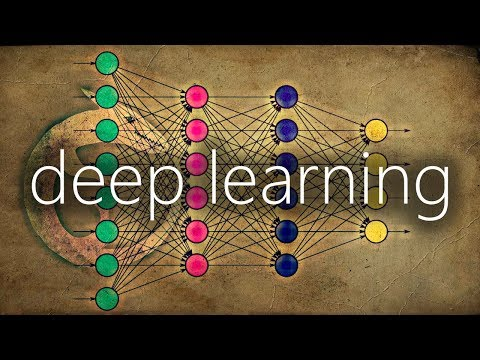

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('YRhxdVk_sIs')

## Transfer Learning

The most popular DCNN architectures have been designed and trained on large generic image libraries such as ImageNet, mostly developed as a result of international computer vision competitions and primarily for application to close-range imagery with small spatial footprints.

These applications have involved design and implementation of new or modified DCNN architectures, or relatively large existing DCNN architectures, and have largely been limited to satellite imagery. Though powerful, DCNNs are also computationally intensive to train and deploy, very data hungry (often requiring millions of examples to train from scratch), and require expert knowledge to design and optimize. 

We utilize a concept known as ‘transfer learning’, where a model trained on one task is re-purposed on a second related task. Fortunately, several open-source DCNN architectures have been designed for general applicability to the task of recognizing objects and features in non-specific photographic imagery. 

Here, we use existing pre-trained DCNN models that are designed to be transferable for generic image recognition tasks, which facilitates rapid DCNN training when developing classifiers for specific image sets. 

Training is rapid because only the final layers in the DCNN need to be retrained to classify a specific set of objects.

In [2]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)
root = 'esipfed/cdi-workshop'

Set TF_CPP_MIN_LOG_LEVEL to 1 to filter out INFO logs, 2 to additionall filter out WARNING, 3 to additionally filter out ERROR.

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Define inputs

### Model

Which TensorFlow Hub module to use.

See https://github.com/tensorflow/hub/blob/r0.1/docs/modules/image.md

Among many suitable popular and open-source frameworks for image classification using deep convolutional neural networks, we chose MobileNetV2 because it is relatively small and efficient (computationally faster to train and execute) compared to many competing architectures designed to be transferable for generic image recognition tasks, such as Inception, Resnet, and NASnet, and it is smaller and more accurate than MobileNetV1. 

It also is pretrained for various tile sizes (image windows with horizontal and vertical dimensions of 96, 128, 192, and 224 pixels) which allows us to evaluate that effect on classifications. 

![](figs/Slide32.PNG)

All of the aforementioned models are implemented within TensorFlow-Hub, which is a library specifically designed for reusing pre-trained TensorFlow models on new tasks. 

Like MobileNetV1, MobileNetV2 uses depthwise separable convolutions where, instead of doing a 2D convolution with a kernel, the same result is achieved by doing two 1D convolutions with two kernels, k1 and k2, where k = k1 · k2. This requires far fewer parameters, so the model is very small and efficient compared to a model with the same depth using 2D convolution. 

However, V2 introduces two new features to the architecture: 1) shortcut connections between the bottlenecks called inverted residual layers, and 2) linear bottlenecks between the layers. 

A bottleneck layer contains few nodes compared to the previous layers, used to obtain a representation of the input with reduced dimensionality, leading to large savings in computational cost. Residual layers connect the beginning and end of a convolutional layers with a skip connection, which gives the network access to earlier activations that weren’t modified in the convolutional layers, and make very deep networks without commensurate increases in parameters. Inverted residuals are a type of residual layer that has fewer parameters, which leads to greater computational efficiency. A ‘linear’ bottleneck is where the last convolution of a residual layer has a linear output before it is added to the initial activations. This preserves more information than the more-traditional non-linear bottlenecks, which leads to greater accuracy.

In [4]:
## TFHub module
tilesize = 224
module = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_'+str(tilesize)+'/classification/1'

Let's train on the UCMerced dataset

In [5]:
direc = 'merced_tile_'+str(tilesize)+'/'

In [6]:
cats = fs.ls(root+'/imrecog_data/UCMerced_LandUse/Images/train')
len(cats)

19

In [38]:
cats

['esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/agricultural',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/airplane',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/baseballdiamond',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/beach',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/buildings',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/chaparral',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/denseresidential',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/freeway',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/golfcourse',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/harbor',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/intersection',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/mobilehomepark',
 'esipfed/cdi-workshop/imrecog_data/UCMerced_Land

Remember that the S3 is a read-only filesystem, so we need to copy those images and labels over

First, the images. Let's copy the file structure over

In [7]:
import os
os.mkdir(direc)
for cat in cats:
    os.mkdir(direc+os.sep+cat.split('/')[-1])

Now we'll copy the images

In [8]:
from imageio import imread, imwrite
L = []
for cat in cats:
    print("working on ",cat)    
    files = [f for f in fs.ls(cat)]
    L.append(len(files))
    for file in files:
        with fs.open(file, 'rb') as fim:
            image = imread(fim)   
            imwrite(direc+os.sep+cat.split('/')[-1]+os.sep+file.split('/')[-1], image)

working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/agricultural
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/airplane
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/baseballdiamond
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/beach
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/buildings
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/chaparral
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/denseresidential
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/freeway
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/golfcourse
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/harbor
working on  esipfed/cdi-workshop/imrecog_data/UCMerced_LandUse/Images/train/intersection
working on  esipfed/cdi-workshop/imrecog_dat

Let's count the files we have to train with

In [9]:
import numpy as np
np.sum(L)

1329

We'll read the labels into an array, and then write them out to a file

In [10]:
with fs.open(root+'/imrecog_data/UCMerced_LandUse/labels.txt', 'rb') as f:
      labels = f.readlines()

labels = [x.strip().decode() for x in labels]

Let's quickly check that we the number of labels equals the number of subdirectories of images

In [11]:
len(cats) == len(labels)

True

Okay, let's write these out again to file

In [12]:
with open('merced_labels.txt', 'a') as the_file:
    for label in labels:
        the_file.write(label+'\n')

In [13]:
labels = 'merced_labels.txt'

We cat use ```!cat``` to check the contents

In [14]:
!cat merced_labels.txt

agricultural
airplane
baseballdiamond
beach
buildings
chaparral
denseresidential
freeway
golfcourse
harbor
intersection
mobilehomepark
overpass
parkinglot
river
runway
sparseresidential
storagetanks
tenniscourt


### Bottlenecks

The first phase analyzes all the images on disk and calculates and caches the bottleneck values for each of them. 

'Bottleneck' is an informal term we often use for the layer just before the final output layer that actually does the classification. (TensorFlow Hub calls this an "image feature vector".) 

This penultimate layer has been trained to output a set of values that's good enough for the classifier to use to distinguish between all the classes it's been asked to recognize. That means it has to be a meaningful and compact summary of the images, since it has to contain enough information for the classifier to make a good choice in a very small set of values. The reason our final layer retraining can work on new classes is that it turns out the kind of information needed to distinguish between all the 1,000 classes in ImageNet is often also useful to distinguish between new kinds of objects.

Because every image is reused multiple times during training and calculating each bottleneck takes a significant amount of time, it speeds things up to cache these bottleneck values on disk so they don't have to be repeatedly recalculated. By default they're stored in the /tmp/bottleneck directory, and if you rerun the script they'll be reused so you don't have to wait for this part again.

In [15]:
### Path to cache bottleneck layer values as files
bn_dir = './merced_bottlenecks'
## Where to save summary logs for TensorBoard.
sumdir = './merced_summaries'

### Training

Once the bottlenecks are complete, the actual training of the top layer of the network begins. You'll see a series of step outputs, each one showing training accuracy, validation accuracy, and the cross entropy. The training accuracy shows what percent of the images used in the current training batch were labeled with the correct class. The validation accuracy is the precision on a randomly-selected group of images from a different set. The key difference is that the training accuracy is based on images that the network has been able to learn from so the network can overfit to the noise in the training data. A true measure of the performance of the network is to measure its performance on a data set not contained in the training data -- this is measured by the validation accuracy. If the train accuracy is high but the validation accuracy remains low, that means the network is overfitting and memorizing particular features in the training images that aren't helpful more generally. Cross entropy is a loss function which gives a glimpse into how well the learning process is progressing. The training's objective is to make the loss as small as possible, so you can tell if the learning is working by keeping an eye on whether the loss keeps trending downwards, ignoring the short-term noise.

By default this script will run 4,000 training steps. Each step chooses ten images at random from the training set, finds their bottlenecks from the cache, and feeds them into the final layer to get predictions. Those predictions are then compared against the actual labels to update the final layer's weights through the back-propagation process. As the process continues you should see the reported accuracy improve, and after all the steps are done, a final test accuracy evaluation is run on a set of images kept separate from the training and validation pictures. This test evaluation is the best estimate of how the trained model will perform on the classification task. You should see an accuracy value of between 90% and 95%, though the exact value will vary from run to run since there's randomness in the training process. This number is based on the percent of the images in the test set that are given the correct label after the model is fully trained.

### Learning rate

This parameter tells the optimizer how far to move the weights in the direction of the gradient for a mini-batch.

If the learning rate is low, then training is more reliable, but optimization will take a lot of time because steps towards the minimum of the loss function are tiny.

If the learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.

The training should start from a relatively large learning rate because, in the beginning, random weights are far from optimal, and then the learning rate can decrease during training to allow more fine-grained weight updates.

In [16]:
num_steps = 2000
learnrate = 0.01

graph = 'merced_test_mobilenetv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'

Model retraining (sometimes called ‘fine-tuning’) consists of tuning the parameters in just the final layer rather than all the weights within all of the network’s layers. Model retraining consists of first using the model, up to the final classifying layer, to generate mage feature vectors for each input tile, 

Then retraining only the final, so-called fully connected, model layer that actually does the classification. 

For each training epoch, feature vectors from tiles are chosen at random from the training set, and feeds them into the final layer to get predict the class. 

Those class predictions are then compared against the actual labels, which is used to update the final layer's weights through back-propagation. 

## Train model

Tensorflow produces a LOT of output which we want to suppress, so we use the %%capture magic command

This will take a few minutes to run, so let's watch a video on convolutions while we wait

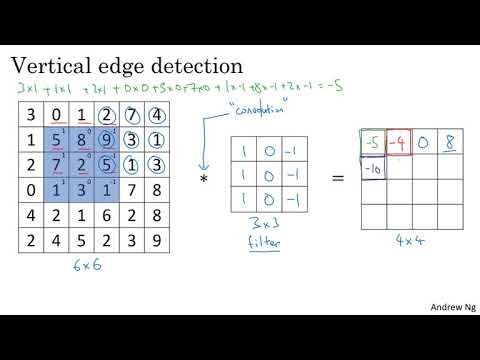

In [17]:
## Filters and feature extraction
YouTubeVideo('XuD4C8vJzEQ') ##11 mins

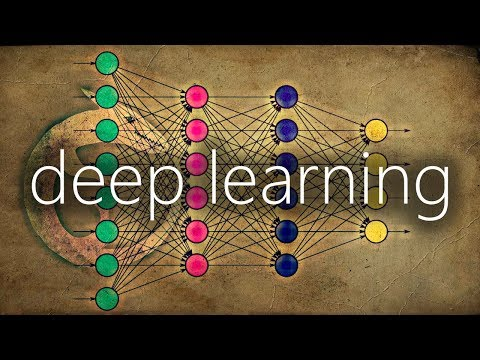

In [18]:
## learnable parameters
YouTubeVideo('gmBfb6LNnZs') ##7 mins

![](figs/Slide41.PNG)

![](figs/Slide42.PNG)

![](figs/Slide43.PNG)

![](figs/Slide44.PNG)

In [19]:
## 6 mins
## (monitor top in bash)

In [20]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --bottleneck_dir $bn_dir --summaries_dir $sumdir \
                  --learning_rate $learnrate --output_labels $labels --output_graph $graph

## Test the model

First, we define some routines to read the model file, normalize an image, and make a model prediction

In [21]:
# =========================================================
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

Load the graph (model) and the classes into the workspace

In [22]:
g = load_graph(graph)

In [23]:
classes = [line.rstrip() for line in tf.gfile.GFile(labels)]

Load in a test image and show it

In [24]:
with fs.open(root+'/imrecog_data/UCMerced_LandUse/Images/train/beach/beach99.jpg', 'rb') as fim:
    image = imread(fim) 

(-0.5, 255.5, 255.5, -0.5)

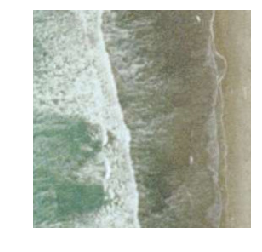

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')

Get a model prediction

In [26]:
# =========================================================
def norm_im(image, tile):
   input_mean = 0 #128
   input_std = 255 #128

   input_name = "file_reader"
   output_name = "normalized"
   float_caster = tf.image.resize_images(tf.cast(image, tf.float32), [tile,tile])

   dims_expander = tf.expand_dims(float_caster, 0);
   normalized = tf.divide(tf.subtract(dims_expander, [input_mean]), [input_std])
   sess = tf.Session()
   return np.squeeze(sess.run(normalized))

# =========================================================
def getCP(tmp, graph):  

   input_name = "import/Placeholder" 
   output_name = "import/final_result" 
   input_operation = graph.get_operation_by_name(input_name);
   output_operation = graph.get_operation_by_name(output_name);

   with tf.Session(graph=graph) as sess:
      results = sess.run(output_operation.outputs[0],
                      {input_operation.outputs[0]: np.expand_dims(tmp, axis=0)})
   results = np.squeeze(results)

   # Sort to show labels of first prediction in order of confidence
   top_k = results.argsort()[-len(results):][::-1]

   return top_k[0], results[top_k[0]], results[top_k], top_k


In [27]:
res = getCP(norm_im(image, tilesize), g)
res

(3,
 0.9961532,
 array([9.96153176e-01, 1.64408772e-03, 1.62670424e-03, 2.20331523e-04,
        9.61176556e-05, 6.77586577e-05, 4.64962213e-05, 2.85624283e-05,
        2.27598157e-05, 2.12923751e-05, 1.82812237e-05, 1.30903072e-05,
        1.30007074e-05, 1.15436205e-05, 7.05847287e-06, 4.97554265e-06,
        2.62116441e-06, 1.50069877e-06, 5.56933855e-07], dtype=float32),
 array([ 3,  8, 14,  5,  0,  9, 15, 13,  2,  7, 10,  6, 16, 18,  1,  4, 17,
        12, 11]))

What does this output mean? Well, the first number is the numeric class

In [28]:
classes[res[0]]

'beach'

The 2nd number is the posterior probability of that prediction. The third array is the probability of each class. The fourth is the order

In [29]:
ordered_classes = [classes[k] for k in res[3]]
ordered_classes

['beach',
 'golfcourse',
 'river',
 'chaparral',
 'agricultural',
 'harbor',
 'runway',
 'parkinglot',
 'baseballdiamond',
 'freeway',
 'intersection',
 'denseresidential',
 'sparseresidential',
 'tenniscourt',
 'airplane',
 'buildings',
 'storagetanks',
 'overpass',
 'mobilehomepark']

Text(0,0.5,'Probability of that class')

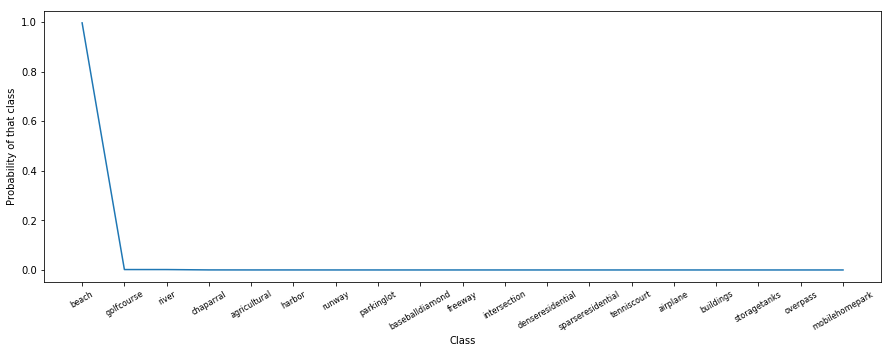

In [30]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(classes)), res[2])
plt.xticks(np.arange(len(classes)),ordered_classes)
plt.setp(plt.gca().get_xticklabels(), rotation=30, fontsize=8)
plt.xlabel('Class'); plt.ylabel('Probability of that class')

## Tidying up

The workspace we have is limited so its best to tidy up as we go

In [31]:
!rm -rf merced_summaries
!rm -rf merced_bottlenecks
!rm -rf merced_tile_224

Don't remove ```merced_labels.txt``` or ```merced_test_mobilenetv2_224_2000_0.01.pb``` because we'll use those files in another lesson

## Other models

(please run in your own time, not in class)

### MobileNetV2, 96 pixel tile

In [32]:
module = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/classification/1'
graph = 'merced_test_mobilenetv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'
num_steps = 2000
learnrate = 0.01
bn_dir = './merced_bottlenecks_96'
sumdir = './merced_summaries_96'

Run the script

In [33]:
%%capture 
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --learning_rate $learnrate --bottleneck_dir $bn_dir --summaries_dir $sum_dir \
                  --output_labels $labels --output_graph $graph

SystemExit: 2

### Inception V3

In [34]:
module = 'https://tfhub.dev/google/imagenet/inception_v3/classification/1'
num_steps = 2000
learnrate = 0.01
bn_dir = './merced_bottlenecks_i3'
sumdir = './merced_summaries_i3'

import tensorflow_hub as tfhub
m = tfhub.Module(module)
tilesize, _ = tfhub.get_expected_image_size(m)
print("tilesize = %i " % tilesize)

graph = 'merced_inceptionv3_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'

tilesize = 299 


Run the script

In [35]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --learning_rate $learnrate --bottleneck_dir $bn_dir --summaries_dir $sum_dir \
                  --output_labels $labels --output_graph $graph

SystemExit: 2

### Inception-Resnet V2

In [36]:
module = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/1'
num_steps = 2000
learnrate = 0.01
bn_dir = './merced_bottlenecks_ir2'
sumdir = './merced_summaries_ir2'

m = tfhub.Module(module)
tilesize, _ = tfhub.get_expected_image_size(m)
print("tilesize = %i " % tilesize)

graph = 'merced_irv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'

tilesize = 299 


Run the script

In [37]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --learning_rate $learnrate --bottleneck_dir $bn_dir --summaries_dir $sum_dir \
                  --output_labels $labels --output_graph $graph

SystemExit: 2